# Parameter Tuning Tutorial    

<b> Objective:</b> 
This tutorial covers how to perform hyperparameter tuning on a random forest model using sklearn's GridSearchCV and RandomSearchCV. 

 **Brief Overview of Random Forests from** [TowardDataScience](https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76): Click on hyperlink to learn more.
> A random forest is a model made up of many decision trees. Rather than just simply averaging the prediction of trees (which we could call a “forest”), this model uses two key concepts that gives it the name random:
1. Random sampling of training data points when building trees
2. Random subsets of features considered when splitting nodes

**The Dataset**
The random forest model will be trained to recognize handwritten digits from the MNIST database. Each greyscale image is 28 x 28, representing the digits 0-9, and consists of 60,000 training images and 10,000 test images. To reduce computational time, this tutorial uses only a subset of the full dataset (10,000 train images and 1,000 test images). Assuming a Gaussian distribution for the MNIST dataset, the dataset is also standardized such that each feature has a mean of 0 and a standard deviation of 1.

# Hyperparameter Tuning Methods

  The base random forest model which will be tuned is initialized with 500 estimators and a random state of 42. Using five-fold cross validation, this base model has an mean accuracy score of 0.89 with a standard deviation of 0.02.  
  
  1. GridSearchCV

This function allows you to run an exhaustive search on all of the possible parameters and parameter combinations as inputs to the Random Forest model and returns the parameters that gives the best performance. 

  2. RandomizedSearchCV

Instead of trying out an exhaustive list of parameters and parameter combinations like GridSearchCV, only a fixed number of parameter combinations is sampled from the full sample space containing all possible combinations of parameter settings. The number of parameter settings that are tried is given by n_iter. 


# Code 


Code is structured in the following order.
   1. Loading and Preprocessing Data 
   2. Building Base Random Forest Model 
   3. Tuning the number of features
   4. Tuning the depths of the trees
   5. Grid Search Tuning 
   6. Random Search Tuning
   7. Heat Map of Classification Accuracy when tuning features and trees simultaneously
   8. Summary of Results

In [3]:
from sklearn.datasets import fetch_openml
# Load data from https://www.openml.org/d/554
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Section One: Loading and Preprocessing Data

There are 70,000 images of handwritten digits in this dataset. Each 28x28 pixel image has been transformed into a 1D vector with 784 features.


In [6]:
# Load the dataset
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

# Check dimensions of the data
images.shape

(70000, 784)

Visualize the data. Use PIL to reshape and create a new image object and matplotlib to visualize the numpy array.


label: 9


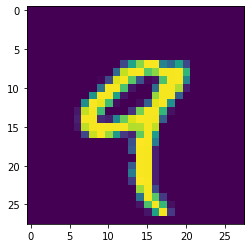

In [6]:
# Pick the fifth image from the dataset (it's a 9)
i = 4
image, label = images[i], labels[i]

# Print the image
output = Image.new("L", (28, 28))
output.putdata(image)
print('label:',label)
plt.imshow(np.asarray(output))

Split the data into training and testing samples. To reduce computational time, use only 10,000 samples for training and 1000 for testing.


In [8]:
# Splitting the data into training and testing samples
from sklearn.model_selection import train_test_split
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, train_size = 10000,
                                                                        test_size = 1000, random_state = 42)
print('Train samples:', images_train.shape[0])
print('Test samples:', images_test.shape[0])

Train samples: 10000
Test samples: 1000


Standardize the data such that each feature has a mean of 0 and a standard deviation of 1.


In [9]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
images_train = scaler.fit_transform(images_train)
images_test = scaler.transform(images_test)

## Section Two: Create and evaluate base Random Forest model with 500 estimators.

Set up a random forest classifier with 500 trees, leaving other parameters as default parameters.


In [20]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Set up classifier and train classifer
clf = RandomForestClassifier(n_estimators=500, random_state = 42)
print(clf)
clf.fit(images_train, labels_train)

# Test classifier
predicted_labels = clf.predict(images_test)

# Evaluate classifier
print("Accuracy: ", accuracy_score(labels_test, predicted_labels))

# Using cross validation to evaluate performance. Compute mean score and 95% interval of score estimate
scores = cross_val_score(clf, images_test, labels_test, cv=5, scoring='accuracy')
print(scores)
print("Cross-Validation (CV=5) Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy:  0.954
[0.91133005 0.89108911 0.90049751 0.89393939 0.87755102]
Cross-Validation (CV=5) Accuracy: 0.89 (+/- 0.02)
CPU times: user 25.3 s, sys: 258 ms, total: 25.6 s
Wall time: 25.7 s


## Section Three: Tuning number of features.

In [11]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Variable to store the accuracies of each random forest classifier with varying number of features
accuracies = []
# Number of features to perform a hyperparameter sweep
features = np.logspace(2.0, 10.0, num=20, base=2.0, endpoint = False, dtype = int)

# Number of experiments to run for each feature value
num_trials = 10

feature_dataObj = pd.DataFrame()
feature_list = []
accuracy_scores = []

for feature in features:
    print(feature)
    
    for t in range(num_trials):
        clf = RandomForestClassifier(n_estimators=500, max_features = feature, max_depth = 5, n_jobs = -2)
        clf.fit(images_train, labels_train)

        # Test classifier
        predicted_labels = clf.predict(images_test)

        # Evaluate classifier
        score = accuracy_score(labels_test, predicted_labels)
        accuracy_scores.append(score)
        feature_list.append(feature)
        
feature_dataObj['Feature List'] = feature_list
feature_dataObj['Accuracy'] = accuracy_scores      

4
5
6
9
12
16
21
27
36
48
64
84
111
147
194
256
337
445
588
776
CPU times: user 5h 9min 11s, sys: 2min 52s, total: 5h 12min 3s
Wall time: 35min 29s


     Feature List  Accuracy
0               4     0.845
1               4     0.844
2               4     0.839
3               4     0.838
4               4     0.838
..            ...       ...
195           776     0.793
196           776     0.792
197           776     0.794
198           776     0.794
199           776     0.788

[200 rows x 2 columns]


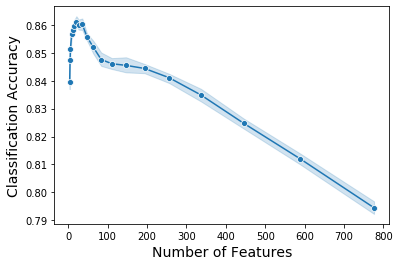

In [12]:
import seaborn as sns
sns.lineplot(x='Feature List', y='Accuracy',data=feature_dataObj, marker='o')
# plt.title('Varying Max_Features for MNIST Data')
plt.xlabel('Number of Features',fontsize=14)
plt.ylabel('Classification Accuracy',fontsize=14)
print(feature_dataObj)
# save the figure to the current working directory
plt.savefig('varying_features_plot.png', dpi=300, bbox_inches='tight')

## Section Four: Tuning maximum depth of trees.

In [8]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Variable to store the accuracies of each random forest classifier with varying number of depths
accuracies = []
# Number of depths to perform a hyperparameter sweep
depths = np.logspace(2.0, 8.0, num = 10, base=2.0, endpoint = False, dtype = int)

# Number of experiments to run for each depth value
num_trials = 10

depth_dataObj = pd.DataFrame()
depth_list = []
accuracy_scores = []

for depth in depths:
    print(depth)
    
    for t in range(num_trials):
        clf = RandomForestClassifier(n_estimators=500, max_depth = depth)
        clf.fit(images_train, labels_train)

        # Test classifier
        predicted_labels = clf.predict(images_test)

        # Evaluate classifier
        score = accuracy_score(labels_test, predicted_labels)
        accuracy_scores.append(score)
        depth_list.append(depth)
        
depth_dataObj['Depth List'] = depth_list
depth_dataObj['Accuracy'] = accuracy_scores 

4
6
9
13
21
32
48
73
111
168
CPU times: user 25min 45s, sys: 11 s, total: 25min 56s
Wall time: 25min 59s


    Depth List  Accuracy
0            4     0.812
1            4     0.812
2            4     0.814
3            4     0.808
4            4     0.818
..         ...       ...
95         168     0.954
96         168     0.959
97         168     0.959
98         168     0.959
99         168     0.957

[100 rows x 2 columns]


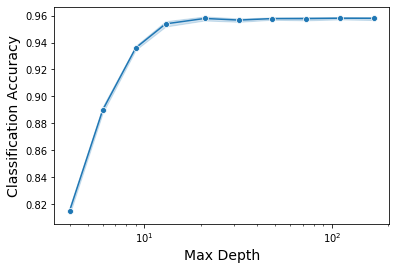

In [11]:
sns.lineplot(x='Depth List', y='Accuracy',data = depth_dataObj,marker='o')
plt.xlabel('Max Depth',fontsize=14)
plt.ylabel('Classification Accuracy',fontsize=14)
print(depth_dataObj)
plt.xscale('log')
plt.savefig('varying_depths_plot.png', dpi=300, bbox_inches='tight')

## Section Five: Grid Search Tuning

In [94]:
%%time
from sklearn.model_selection import GridSearchCV

# Set up classifier
clf = RandomForestClassifier(n_estimators = 500, random_state=42)

# Set up combinations of paramters to tune
param_grid = { 
    'max_features': np.logspace(2.0, 10, num = 10, base=2.0, endpoint = False, dtype = int),
    'max_depth' : np.logspace(2.0, 8.0, num = 10, base=2.0, endpoint = False, dtype = int),
}

# Perform Grid Search Tuning
CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 3)
CV_clf.fit(images_train, labels_train)

CV_clf.best_params_

CPU times: user 3h 54min 26s, sys: 1min 12s, total: 3h 55min 39s
Wall time: 12h 1min 47s


{'max_depth': 21, 'max_features': 21}

Evalulate the performance Random Forest classifier using the best combination of parameters found by GridSearchCV. 


In [95]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Set up classifier and train classifer
clf = RandomForestClassifier(n_estimators=500, max_features = 21, max_depth = 21, random_state = 42)
print(clf)
clf.fit(images_train, labels_train)

# Test classifier
predicted_labels = clf.predict(images_test)

# Evaluate classifier
print("Accuracy: ", accuracy_score(labels_test, predicted_labels))

# Using cross validation to evaluate performance. Compute mean score and 95% interval of score estimate
scores = cross_val_score(clf, images_test, labels_test, cv=5, scoring='accuracy')
print(scores)
print("Cross-Validation (CV=5) Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=21, max_features=21, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy:  0.957
[0.90147783 0.88613861 0.89054726 0.87878788 0.89285714]
Cross-Validation (CV=5) Accuracy: 0.89 (+/- 0.01)


## Section Six: Random Search Tuning.

In [32]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Set up classifier
clf = RandomForestClassifier(n_estimators = 500, random_state=42)

# Set up combinations of paramters to tune
param_grid = { 
    'max_features': np.logspace(2.0, 10, num= 10, base=2.0, endpoint = False, dtype = int),
    'max_depth' : np.logspace(2.0, 8.0, num = 10, base=2.0, endpoint = False, dtype = int),
}

CV_clf = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, n_iter = 50,
                            cv = 3, random_state=42)

CV_clf.fit(images_train, labels_train)

CV_clf.best_params_

CPU times: user 2h 19min 36s, sys: 29.2 s, total: 2h 20min 6s
Wall time: 7h 38min 25s


{'max_features': 21, 'max_depth': 111}

Evalulate the performance Random Forest classifier using the best combination of parameters found by RandomizedSearchCV. 


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Set up classifier and train classifer
clf = RandomForestClassifier(n_estimators=500, max_features = 21, max_depth = 111, random_state = 42)
print(clf)
clf.fit(images_train, labels_train)

# Test classifier
predicted_labels = clf.predict(images_test)

# Evaluate classifier
print("Accuracy: ", accuracy_score(labels_test, predficted_labels))

# Using cross validation to evaluate performance. Compute mean score and 95% interval of score estimate
scores = cross_val_score(clf, images_test, labels_test, cv=5, scoring='accuracy')
print(scores)
print("Cross-Validation (CV=5) Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=111, max_features=21, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
Accuracy:  0.957
[0.90147783 0.88613861 0.89054726 0.87373737 0.89795918]
Cross-Validation (CV=5) Accuracy: 0.89 (+/- 0.02)


## Section Seven: Heat Map

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import numpy as np

features = np.logspace(2.0, 10, num= 10, base=2.0, endpoint = False, dtype = int)
depth =  np.logspace(2.0, 8.0, num = 10, base=2.0, endpoint = False, dtype = int)
grid = {'n_features': features, 'n_depth': depth}
param_combo = []
acc_scores = []

list_features = []
list_depths = []

num_trials = 1
trial_score = 0
for count, params in enumerate(ParameterGrid(grid)):
    print(params)
    for t in range(num_trials):

        # Obtain similarity matrix from USPORF classifier
        clf = RandomForestClassifier(n_estimators = 500,
                                       max_features = params['n_features'],
                                       max_depth = params['n_depth'],
                                       random_state=42,
                                       n_jobs = -2)

        clf.fit(images_train, labels_train)
        
        # Test classifier
        predicted_labels = clf.predict(images_test)

        # Evaluate classifier
        score = accuracy_score(labels_test, predicted_labels)
        print(score)

        # Save tree information and associated ARI score
        param_combo.append(params)
        trial_score += score
        list_depths.append(params['n_depth'])
        list_features.append(params['n_features'])
        
    print('trial score:',trial_score/num_trials)
    acc_scores.append(trial_score/num_trials)
    trial_score = 0

{'n_depth': 4, 'n_features': 4}
0.814
trial score: 0.814
{'n_depth': 4, 'n_features': 6}
0.824
trial score: 0.824
{'n_depth': 4, 'n_features': 12}
0.82
trial score: 0.82
{'n_depth': 4, 'n_features': 21}
0.821
trial score: 0.821
{'n_depth': 4, 'n_features': 36}
0.809
trial score: 0.809
{'n_depth': 4, 'n_features': 64}
0.809
trial score: 0.809
{'n_depth': 4, 'n_features': 111}
0.797
trial score: 0.797
{'n_depth': 4, 'n_features': 194}
0.79
trial score: 0.79
{'n_depth': 4, 'n_features': 337}
0.768
trial score: 0.768
{'n_depth': 4, 'n_features': 588}
0.733
trial score: 0.733
{'n_depth': 6, 'n_features': 4}
0.859
trial score: 0.859
{'n_depth': 6, 'n_features': 6}
0.87
trial score: 0.87
{'n_depth': 6, 'n_features': 12}
0.882
trial score: 0.882
{'n_depth': 6, 'n_features': 21}
0.89
trial score: 0.89
{'n_depth': 6, 'n_features': 36}
0.894
trial score: 0.894
{'n_depth': 6, 'n_features': 64}
0.891
trial score: 0.891
{'n_depth': 6, 'n_features': 111}
0.89
trial score: 0.89
{'n_depth': 6, 'n_featu

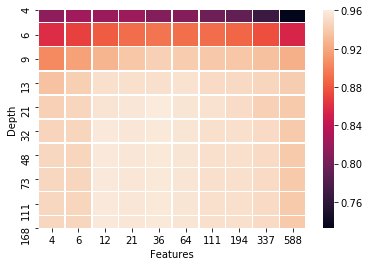

In [19]:
features = np.logspace(2.0, 10, num= 10, base=2.0, endpoint = False, dtype = int)
depths =  np.logspace(2.0, 8.0, num = 10, base=2.0, endpoint = False, dtype = int)
data = {'Depth':list_depths, 'Features':list_features, 'Accuracy': acc_scores}
df = pd.DataFrame(data) 
df = df.pivot("Depth", "Features", "Accuracy")
ax = sns.heatmap(df,linewidths=.5)

# Summary of Results

|Models         |Performance   |                    Best Params   |        Computation Time    |
|---------------|--------------|----------------------------------|----------------------------|
|Base Model     | 0.89 ± 0.02  | n_features = 28, max_depth = None|CPU total time: 25.3s       |  
|Grid Search    | 0.89 ± 0.01  | n_features = 21, max_depth = 21  |CPU total time: 3h 55min 39s|
|Random Search  | 0.90 ± 0.02  | n_features = 21, max_depth = 111 |CPU total time: 2h 6min 6s  | 


<img src="varying_features_plot.png" width="45%" align="left">
<img src="varying_depths_plot.png" width="45%" align="right">
<img src="Heatmap.png" width="45%" align="left">